In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
tf.config.run_functions_eagerly(True)

from msfm.utils import files
from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline

from msfm.utils import input_output, files, scales

from deepsphere.healpy_layers import HealpySmoothing

24-05-17 14:28:42   imports.py INF   Setting up healpy to run on 10 CPUs 
24-05-17 14:28:43   imports.py INF   Setting up healpy to run on 10 CPUs 


In [2]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# 246pt in inches (for the Phys Rev template)
half_linewidth = 3.41
# 510pt in inches (figure* environment in the Phys Rev template)
full_linewidth = 7.06

### data

In [3]:
conf = "/Users/arne/git/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
conf = files.load_config(conf)
params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
tfr_pattern = "/Users/arne/data/DESY3/paper_1/DESy3_grid_dmb_0000.tfrecord"

grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
)

data_vec_pix = grid_pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

24-05-17 14:28:43     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-17 14:28:43     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


2024-05-17 14:28:43.779554: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-17 14:28:43.779581: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-17 14:28:43.779588: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-17 14:28:43.779607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-17 14:28:43.779624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### map: smoothing

In [4]:
# dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v8/combined/linear_bias/dlss_config.yaml"
# dlss_conf = input_output.read_yaml(dlss_conf)

dlss_conf = {
    "scale_cuts" : {
          "n_sigma_support": 5,
          "arcmin": True,
          "lensing": {
            # 6 Mpc/h transverse comoving scale -> arcmin
            "theta_fwhm": [22.1, 15.1, 11.2, 9.4]
          },
        "clustering" : {
            # 16 Mpc/h transverse comoving scale -> arcmin
            "theta_fwhm": [65.1, 44.5, 34.1, 28.5]
        },
    }
}

            
mask_dict = files.get_tomo_dv_masks(conf)
mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)
# mask = mask.numpy()

fwhm = dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"] + dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
    
smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "mask": mask,
    "fwhm": fwhm,
    "arcmin": dlss_conf["scale_cuts"]["arcmin"],
    "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    # 1% without normalization
    "white_noise_sigma": [0.00107639, 0.00119809, 0.00136985, 0.00326847, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
    "data_path": ".",
}

# mask = mask.astype(bool)

smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-05-17 14:28:43     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma [0.00107639, 0.00119809, 0.00136985, 0.00326847, 0.26904975, 0.14492357, 0.11769442, 0.12976879] to the smoothed map


In [32]:
grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        noise_indices=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

for dv, cosmo, index in grid_dset.skip(11).take(1):
    dv_raw = dv[0]
    dv = smoothing_layer(dv)[0]

print(dv.shape)
print(dv_raw.shape)

24-05-17 18:28:03 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-17 18:28:03 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-05-17 18:28:03 grid_pipelin INF   Including noise_indices = [0, 1, 2] 
24-05-17 18:28:03 grid_pipelin INF   Interleaving with n_readers = 1 
24-05-17 18:28:03 grid_pipelin INF   Batching into 1 elements locally 
24-05-17 18:28:03 grid_pipelin WAR   Tracing _augmentations 
24-05-17 18:28:03 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'i_noise']) 
24-05-17 18:28:03 grid_pipelin INF   Successfully generated the grid validation set with element_spec (TensorSpec(shape=(None, 464896, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,),

/opt/homebrew/Caskroom/miniforge/base/envs/dlss/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(464896, 8)
(464896, 8)


2024-05-17 18:28:09.252727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# for the rotated DES footprint
rot = (90, -30, 0)

gnoms = np.zeros((x_pix, y_pix, n_z))
gnoms_raw = np.zeros((x_pix, y_pix, n_z))

for i_z in range(n_z):
    # default
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = dv[:, i_z]

    gnom = hp.gnomview(
        hp_map,
        nest=True,
        rot=(90, -30, 0),
        reso=reso,
        xsize=x_pix,
        ysize=y_pix,
        return_projected_map=True,
        no_plot=True,
    )
    gnoms[..., i_z] = gnom

    # raw
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = dv_raw[:,i_z]

    gnom_raw = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
    gnoms_raw[..., i_z] = gnom_raw

gnoms = np.ma.masked_where(gnoms == 0, gnoms)
gnoms_raw = np.ma.masked_where(gnoms_raw==0, gnoms_raw)

# map: raw vs. smoothed

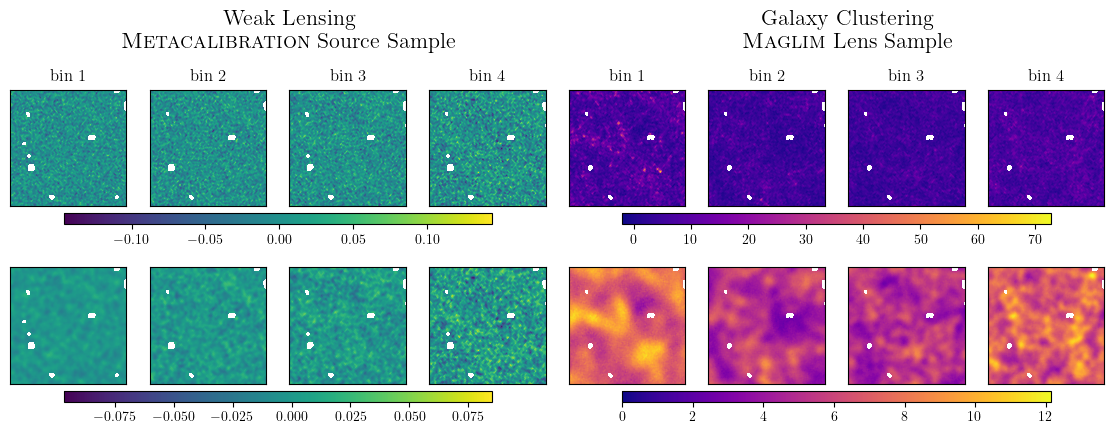

In [35]:
# fig, ax = plt.subplots(figsize=(16, 4), nrows=2, ncols=n_z)
fig, ax = plt.subplots(figsize=(2*full_linewidth, 0.6*full_linewidth), nrows=2, ncols=n_z)

wl_min = np.array(gnoms[..., :n_z_metacal]).min()
wl_max = np.array(gnoms[..., :n_z_metacal]).max()
wl_min_raw = np.array(gnoms_raw[..., :n_z_metacal]).min()
wl_max_raw = np.array(gnoms_raw[..., :n_z_metacal]).max()

gc_min = np.array(gnoms[..., n_z_metacal:]).min()
gc_max = np.array(gnoms[..., n_z_metacal:]).max()
gc_min_raw = np.array(gnoms_raw[..., n_z_metacal:]).min()
gc_max_raw = np.array(gnoms_raw[..., n_z_metacal:]).max()

i_n = 0
for i_z in range(n_z):
    # lensing
    if i_z < n_z_metacal:
        vmin = wl_min
        vmax = wl_max
        vmin_raw = wl_min_raw
        vmax_raw = wl_max_raw

        cmap = "viridis"

    # clustering
    else:
        vmin = gc_min
        vmax = gc_max
        vmin_raw = gc_min_raw
        vmax_raw = gc_max_raw

        cmap = "plasma"

    # plotting
    im_raw = ax[0, i_z].imshow(gnoms_raw[..., i_z], vmin=vmin_raw, vmax=vmax_raw, cmap=cmap)
    im = ax[1, i_z].imshow(gnoms[..., i_z], vmin=vmin, vmax=vmax, cmap=cmap)

    if i_z == 0:
        fig.colorbar(im_raw, ax=ax[0, :n_z_metacal], orientation="horizontal", shrink=0.8, aspect=40, pad=0.05)
        fig.colorbar(im, ax=ax[1, :n_z_metacal], orientation="horizontal", shrink=0.8, aspect=40, pad=0.05)

    if i_z == 4:
        fig.colorbar(im_raw, ax=ax[0, n_z_metacal:], orientation="horizontal", shrink=0.8, aspect=40, pad=0.05)
        fig.colorbar(im, ax=ax[1, n_z_metacal:], orientation="horizontal", shrink=0.8, aspect=40, pad=0.05)

    for i in range(2):
        ax[i, i_z].set_xticks([])
        ax[i, i_z].set_yticks([])
        ax[i, i_z].set_aspect("equal")


for i, bin_number in enumerate(range(1, 5)):
    ax[0, i].set(title=f"bin {bin_number}")

for i, bin_number in enumerate(range(1, 5)):
    ax[0, i + 4].set(title=f"bin {bin_number}")

# title_ax = fig.add_subplot(121, frame_on=False)
# title_ax.xaxis.set_visible(False)
# title_ax.yaxis.set_visible(False)
# title_ax.set_title(r"Weak Lensing/Source \textsc{Metacalibration} Sample", fontsize=14, loc="center", y=1.1)

# title_ax = fig.add_subplot(122, frame_on=False)
# title_ax.xaxis.set_visible(False)
# title_ax.yaxis.set_visible(False)
# title_ax.set_title(r"Galaxy Clustering/Lens \textsc{Maglim} Sample", fontsize=14, loc="center", y=1.1)

# fig.text(0, 1.5, r"Weak Lensing \\ \textsc{Metacalibration} Source Sample", ha="center", va="center", fontsize=16, transform=ax[0, 2].transAxes)
# fig.text(0, 1.5, r"Galaxy Clustering: \textsc{Maglim} Lens Sample", ha="center", va="center", fontsize=16, transform=ax[0, 6].transAxes)
fig.text(0, 1.6, r"Weak Lensing", ha="center", va="center", fontsize=16, transform=ax[0, 2].transAxes)
fig.text(0, 1.4, r"\textsc{Metacalibration} Source Sample", ha="center", va="center", fontsize=16, transform=ax[0, 2].transAxes)
fig.text(0, 1.6, r"Galaxy Clustering", ha="center", va="center", fontsize=16, transform=ax[0, 6].transAxes)
fig.text(0, 1.4, r"\textsc{Maglim} Lens Sample", ha="center", va="center", fontsize=16, transform=ax[0, 6].transAxes)

# fig.tight_layout()
fig.savefig("plots/placeholder_smoothing_map.pdf", bbox_inches="tight")